<a href="https://colab.research.google.com/github/SasiKaw/Skin-Cancer-AI-Interpretability/blob/main/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch

# Check PyTorch Version
print("PyTorch Version:", torch.__version__)

# Check that we received a GPU for train the AI
if torch.cuda.is_available():
    print("GPU is ready")
else:
    print("GPU is not ready.")

PyTorch Version: 2.9.0+cu128
Super! GPU එක ලෑස්තියි. අපිට AI එක හදන්න පටන් ගන්න පුළුවන්. 🚀


In [3]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 7.4 MB/s eta 0:00:00


In [4]:
import medmnist
from medmnist import DermaMNIST
import torchvision.transforms as transforms

# Convert images into numbers (Tensors) that AI can understand
data_transform = transforms.Compose([transforms.ToTensor()])

# Download the dataset for training
train_dataset = DermaMNIST(split='train', transform=data_transform, download=True)

# Download the dataset for testing
test_dataset = DermaMNIST(split='test', transform=data_transform, download=True)

print("n---- Data Extraction Completed! ----")
print("Training Dataset Size: ", len(train_dataset))
print("Testing Dataset Size: ", len(test_dataset))



100%|██████████| 19.7M/19.7M [00:02<00:00, 8.05MB/s]


n---- Data Extraction Completed! ----
Training Dataset Size:  7007
Testing Dataset Size:  2005


This is the first 5 images of the traning set:


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3512 (\N{SINHALA LETTER MAYANNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Sinhala natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3535 (\N{SINHALA VOWEL SIGN AELA-PILLA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3515 (\N{SINHALA LETTER RAYANNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3505 (\N{SINHALA LETTER DANTAJA NAYANNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw

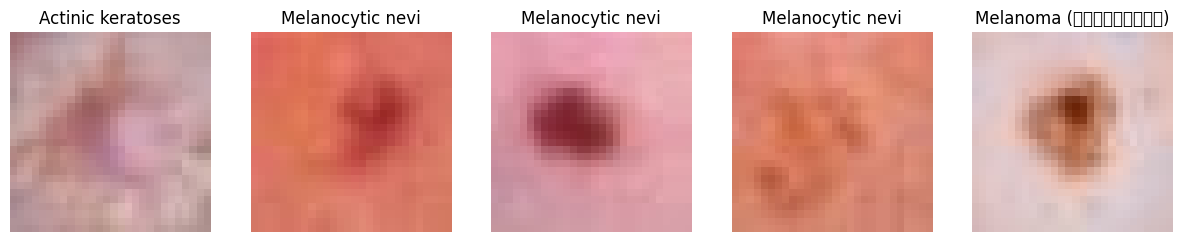

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 7 types of cancer and their names
classes = {
    0: 'Actinic keratoses',
    1: 'Basal cell carcinoma',
    2: 'Benign keratosis',
    3: 'Dermatofibroma',
    4: 'Melanoma',
    5: 'Melanocytic nevi',
    6: 'Vascular lesions'
}

# Create a frame to show 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

print("This is the first 5 images of the traning set:")

for i in range(5):
  # Extract the image and it's label
  image, label = train_dataset[i]

  # Conver the PyTorch Tensor into a normal image
  image = image.numpy().transpose((1, 2, 0))

  # Show the image
  axes[i].imshow(image)
  # Put the label top of the image
  axes[i].set_title(classes[label[0]])
  axes[i].axis('off')

plt.show()


In [37]:
import torch.nn as nn
import torch.nn.functional as F

# Building the Architecture of our AI brain
class SkinCancerAI(nn.Module):
  def __init__(self):
    super(SkinCancerAI, self).__init__()

    # This is eyes of our AI - they identiy the shapes and colors of the images
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

    # This is the decision making part of the AI (Linear Layers) - it analyze the things that see from the eyes
    self.fc1 = nn.Linear(32 * 7 * 7, 128)
    # Choose 1 outof 7 cancer types
    self.fc2 = nn.Linear(128, 7)

  def forward(self, x):
    # This pass our images through the Ai'eyes and MaxPool will use to make the image smaller and extract only important details
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)

    # Flatten the image and pass to the decesion making part
    x = x.view(-1, 32 * 7 * 7)
    x = F.relu(self.fc1(x))
    # Get the final decision
    x = self.fc2(x)
    return x

# Make an object from our AI brain and put into the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SkinCancerAI().to(device)

print("AI Brain Created and put into GPU!")
print(model)


AI Brain Created and put into GPU!
SkinCancerAI(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)


In [ ]:
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)

print("Start the training of the AI.... ⏳")

# We will show the whole dataset to the AI, 5 times
epochs = 5

for epoch in range(epochs):
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze()

        # remove the flase memory from previous round
        optimizer.zero_grad()

        # AI Predictions
        outputs = model(images)
        # Mesure how much AI was loss
        loss = criterion(outputs, labels)
        # Pass the mistake (Loss) throughout the Brain command to fix that mistake (Backpropagation)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Round (Epoch) {epoch+1} finished! Mistaken Value (Loss): {running_loss/len(train_loader):.4f}")

print("\nTraining is finished!")

Start the training of the AI.... ⏳


Image found for number 0 (Max Gradient: 0.023386)


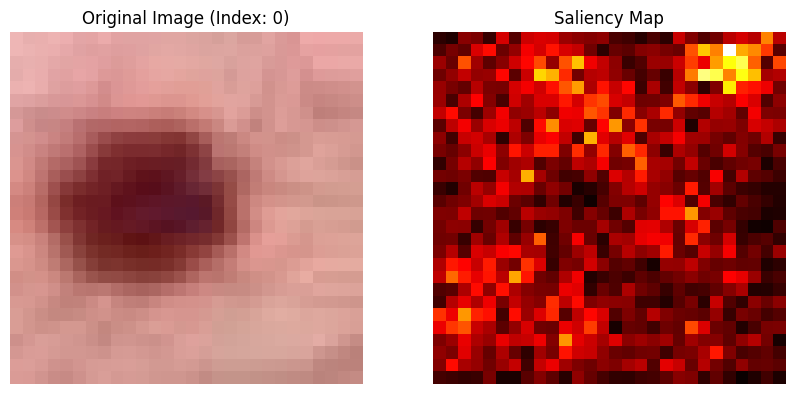

In [41]:
import numpy as np
import matplotlib.pyplot as plt

model.eval()

found_image = False

for i in range(50):
    image, label = test_dataset[i]
    image = image.unsqueeze(0).to(device)
    image.requires_grad_()

    output = model(image)

    output.sum().backward()

    saliency = image.grad.data.abs().squeeze().cpu().numpy()

    # Show only if there is a gradient
    if saliency.max() > 0:
        print(f"Image found for number {i} (Max Gradient: {saliency.max():.6f})")
        saliency = np.amax(saliency, axis=0)
        # Normalization
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
        found_image = True
        break

    # Gradient should be remove before going to the next image
    model.zero_grad()

# Show the image
if found_image:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    original_img = image.squeeze().detach().cpu().numpy().transpose((1, 2, 0))
    ax[0].imshow(original_img)
    ax[0].set_title(f"Original Image (Index: {i})")
    ax[0].axis('off')

    ax[1].imshow(saliency, cmap='hot')
    ax[1].set_title("Saliency Map")
    ax[1].axis('off')

    plt.show()
else:
    print("Even gothrough 50 iamges, can't find a signal so train the NN again with higher epochs")